## Read File

In [268]:
"test"

'test'

In [269]:
import pandas as pd

local_path = "/Users/kneskung/Code/Datamining/esun_sar_baseline/src/"
CUSTINFO_PATH = 'dataset/train_first/public_train_x_custinfo_full_hashed.csv'
PDATE_PATH = 'dataset/train_first/public_x_alert_date.csv'
TDATE_PATH = 'dataset/train_first/train_x_alert_date.csv'
ANSWER_PATH = 'dataset/train_first/train_y_answer.csv'
SAMPLE_PATH = 'dataset/train_first/sample_submission.csv'
CCBA_PATH = local_path + 'train_first/public_train_x_ccba_full_hashed.csv'

ccba = pd.read_csv(CCBA_PATH)
cinfo = pd.read_csv(CUSTINFO_PATH)
pdate = pd.read_csv(PDATE_PATH)
tdate = pd.read_csv(TDATE_PATH)
answer = pd.read_csv(ANSWER_PATH)
sample = pd.read_csv(SAMPLE_PATH)

In [270]:
ccba[:1]

,cust_id,lupay,byymm,cycam,usgam,clamt,csamt,inamt,cucsm,cucah
0,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,0,152628.0,0.0,0.0,0.0,0.0,0.0,0.0


In [271]:
pdate.insert(pdate.shape[1], "data_label", ["test"] * pdate.shape[0], True)
tdate.insert(tdate.shape[1], "data_label", ["train"] * tdate.shape[0], True)
date = pd.concat([pdate, tdate], axis=0)

cinfo = cinfo.merge(date, on='alert_key', how='left')
cinfo = cinfo.merge(answer, on='alert_key', how='left')

In [272]:
cinfo[:1]

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag
0,352249,82595ac69158ae08d34156784bdec0d9e2ca5b242b6d2a...,1,19.0,1465816.0,7,365,test,NaN


In [273]:
pd.unique(ccba['byymm'])

array([  0,  30,  61,  91, 122, 153, 183, 214, 244, 275, 306, 334, 365])

In [274]:
# tuple(alert_date, customer_id) find in ccba (byymm)
from tqdm import tqdm

tqdm.pandas()

columns = ["lupay", "byymm", "cycam", "usgam", "clamt", "csamt", "inamt", "cucsm", "cucah"]


def create_features(record):
    dates = ccba[(ccba.cust_id == record.cust_id) & (ccba.byymm <= record.date)]
    for col in columns:
        record[col + "_mean"] = dates[col].mean()
        record[col + "_sum"] = dates[col].sum()
        record[col + "_count"] = dates[col].count()
        record[col + "_std"] = dates[col].std()
        record[col + "_quantile"] = dates[col].quantile()
    return record


cinfo_aggregated_ccba = cinfo.progress_apply(lambda x: create_features(x), axis=1)
cinfo_aggregated_ccba = cinfo_aggregated_ccba.fillna(0)
cinfo_aggregated_ccba.to_pickle("ccba_all_feature.pkl")


  2%|▏         | 398/25751 [00:04<04:38, 91.09it/s]


KeyboardInterrupt: 

In [639]:
cinfo_aggregated_ccba = pd.read_pickle("ccba_all_feature.pkl")
cinfo_aggregated_ccba.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,lupay_mean,...,cucsm_mean,cucsm_sum,cucsm_count,cucsm_std,cucsm_quantile,cucah_mean,cucah_sum,cucah_count,cucah_std,cucah_quantile
0,352249,82595ac69158ae08d34156784bdec0d9e2ca5b242b6d2a...,1,19.0,1465816.0,7,365,test,0.0,0.000000,...,0.000000,0.0,0,0.000000,0.0,0.000000,0.0,0,0.000000,0.0
1,352253,b212d14cb35676926682b2cf849e295d948888f556c07e...,1,2.0,98177.0,2,365,test,0.0,1359.230769,...,1244.923077,16184.0,13,3027.376848,0.0,0.000000,0.0,13,0.000000,0.0
2,352254,e5b0002791c7852644a2730abeaa893cdf14a072ef7812...,1,19.0,2052922.0,7,365,test,0.0,0.000000,...,0.000000,0.0,0,0.000000,0.0,0.000000,0.0,0,0.000000,0.0
3,352280,74214c478dc6519fbefe4bc31693865bdcd698ab974b64...,3,15.0,201906.0,5,365,test,0.0,6439.384615,...,3538.307692,45998.0,13,1509.895051,2617.0,11119.923077,144559.0,13,40093.452833,0.0
4,352282,0340e7611f0d82c3cb87e6194fa14bb2ccf8afbf1b3418...,1,12.0,7450.0,5,365,test,0.0,0.000000,...,0.000000,0.0,0,0.000000,0.0,0.000000,0.0,0,0.000000,0.0


In [640]:
len(pd.unique(cinfo_aggregated_ccba.cust_id)), len(pd.unique(cinfo.cust_id))

(7708, 7708)

In [675]:
X = cinfo_aggregated_ccba[cinfo_aggregated_ccba['data_label'] == 'train']
test = cinfo_aggregated_ccba[cinfo_aggregated_ccba['data_label'] == 'test']
test = test.fillna(0)
test_alert_keys = test['alert_key']

In [676]:
drop_features = ["alert_key", "cust_id", "data_label", "sar_flag", "date", "risk_rank", "occupation_code"]

In [677]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE()
adasyn = ADASYN()
rus = RandomUnderSampler()

y = X['sar_flag']
dropped_X = X.drop(drop_features, axis=1)
test = test.drop(drop_features, axis=1)
dropped_X = dropped_X.fillna(0)

In [678]:
dropped_X

,total_asset,AGE,lupay_mean,lupay_sum,lupay_count,lupay_std,lupay_quantile,byymm_mean,byymm_sum,byymm_count,...,cucsm_mean,cucsm_sum,cucsm_count,cucsm_std,cucsm_quantile,cucah_mean,cucah_sum,cucah_count,cucah_std,cucah_quantile
1845,241719.0,3,12565.000000,12565.0,1,0.000000,12565.0,0.00,0,1,...,12477.000000,12477.0,1,0.000000,12477.0,0.0,0.0,1,0.0,0.0
1846,599497.0,6,3581.000000,3581.0,1,0.000000,3581.0,0.00,0,1,...,4981.000000,4981.0,1,0.000000,4981.0,0.0,0.0,1,0.0,0.0
1847,51160.0,4,0.000000,0.0,0,0.000000,0.0,0.00,0,0,...,0.000000,0.0,0,0.000000,0.0,0.0,0.0,0,0.0,0.0
1848,3634343.0,6,829364.000000,829364.0,1,0.000000,829364.0,0.00,0,1,...,781279.000000,781279.0,1,0.000000,781279.0,0.0,0.0,1,0.0,0.0
1849,4076287.0,4,636.000000,636.0,1,0.000000,636.0,0.00,0,1,...,3410.000000,3410.0,1,0.000000,3410.0,0.0,0.0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25746,12207.0,2,291542.333333,3498508.0,12,170542.043677,258446.5,167.75,2013,12,...,289567.666667,3474812.0,12,171952.651239,267900.5,0.0,0.0,12,0.0,0.0
25747,259985.0,4,261818.416667,3141821.0,12,485138.753146,53396.5,167.75,2013,12,...,260364.583333,3124375.0,12,480801.790554,58368.0,0.0,0.0,12,0.0,0.0
25748,928963.0,3,0.000000,0.0,0,0.000000,0.0,0.00,0,0,...,0.000000,0.0,0,0.000000,0.0,0.0,0.0,0,0.0,0.0
25749,21647.0,4,0.000000,0.0,0,0.000000,0.0,0.00,0,0,...,0.000000,0.0,0,0.000000,0.0,0.0,0.0,0,0.0,0.0


In [679]:
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from matplotlib import pyplot


def generate_train_dataset(X, y, model):
    X_resampled, y_resampled = model.fit_resample(X, y)

    return train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=123)

In [680]:
import time
from sklearn.metrics import ConfusionMatrixDisplay, average_precision_score, precision_score, recall_score, roc_curve,

auc
from sklearn.preprocessing import MinMaxScaler
from numpy import sort
from sklearn.feature_selection import SelectFromModel


def fit_xgboost(X, y, resampler):
    X_train, X_test, y_train, y_test = generate_train_dataset(X, y, resampler)

    eta = 0.1
    max_depth = 5
    subsample = 0.9
    colsample_bytree = 1
    start_time = time.time()

    params_1 = {
        "booster": "gbtree",
        "eval_metric": "auc",
        "eta": eta,
        "tree_method": 'auto',
        "max_depth": max_depth,
        "sampling_method": "uniform",
        "subsample": subsample,
        "colsample_bytree": colsample_bytree
    }

    model_cls = xgb.XGBClassifier(**params_1, missing=-99)
    model_cls.fit(X_train, y_train)
    y_pred = model_cls.predict(X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    xgb.plot_importance(model_cls, importance_type='cover')
    xgb.plot_importance(model_cls, importance_type='weight')
    xgb.plot_importance(model_cls, importance_type='gain')

    cm = confusion_matrix(y_test, y_pred)
    pyplot.rcParams['axes.grid'] = False
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='g')
    # generate_submission_file(model_cls)
    return model_cls


In [716]:
sample


,alert_key,probability
0,357307,0.000017
1,376329,0.000324
2,373644,0.000372
3,357668,0.000489
4,354443,0.000526
...,...,...
3845,364485,0.997702
3846,363155,0.998987
3847,368710,0.999694
3848,358067,0.999821


In [828]:
import random
def generate_submission_file(_model):
    # d_test = xgb.DMatrix(test)
    # prediction = _model.predict(d_test,outputmargin=False)
    # print(prediction)
    prob_list = _model.predict_proba(test).tolist()
    prob_test = [prob[1] for prob in prob_list]

    lowest_prob = min(prob_test)

    non_predicted_key = sample[~sample['alert_key'].isin(test_alert_keys)]
    non_predicted_key['probability'] = non_predicted_key['probability'].apply(lambda x: random.uniform(0,lowest_prob))

    submission = pd.concat([test_alert_keys, pd.DataFrame({'probability': prob_test})], axis=1)
    submission = pd.concat([submission, non_predicted_key])
    submission = submission.sort_values(by=['probability'], ascending=False)

    submission.to_csv("submission_xgboost.csv", index=False)

In [829]:
# smote_model = fit_xgboost(dropped_X, y, smote)

In [830]:
generate_submission_file(smote_model)

/var/folders/1t/798ky1kx003ft5w1l83k6v9h0000gn/T/ipykernel_20741/2831272249.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_predicted_key['probability'] = non_predicted_key['probability'].apply(lambda x: random.uniform(0,lowest_prob))


In [ ]:
fit_xgboost(dropped_X, y, rus)

In [689]:
import random

random.uniform(10, 30)

17.839443586235518

Accuracy: 94.25%


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.100000001,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=-99, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='binary:hinge', ...)

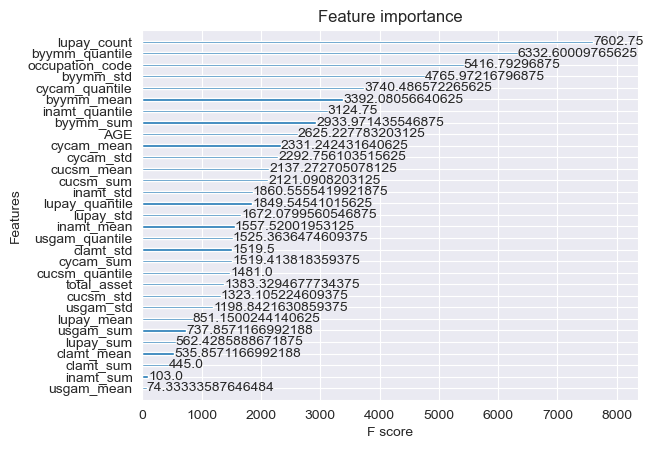

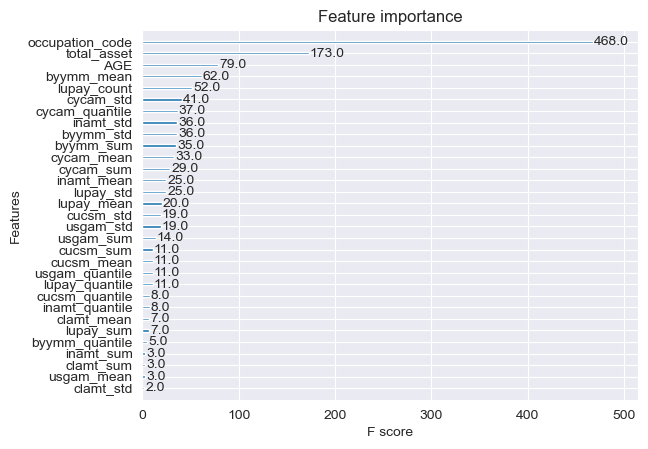

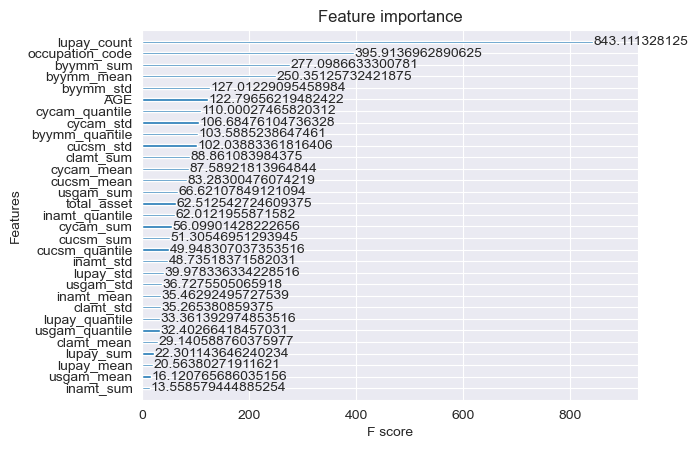

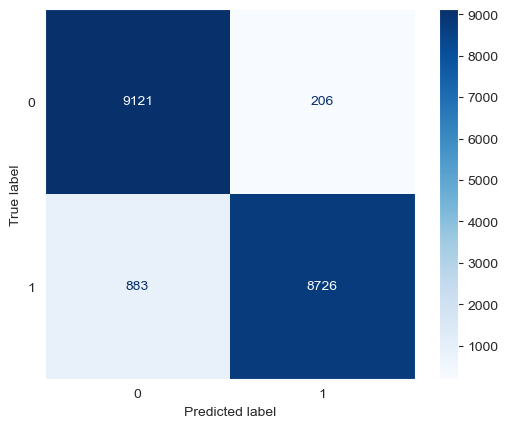

In [597]:
fit_xgboost(dropped_X, y, adasyn)

### Training XGBoost - Over sampling

In [46]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_smote_prep = copy.deepcopy(X)
X_smote_prep = X_smote_prep.dropna()
X_smote_prep = X_smote_prep.drop(['cust_id', 'data_label'], axis=1)
y_smote_prep = X_smote_prep['sar_flag']
X_smote, y_smote = smote.fit_resample(X_smote_prep, y_smote_prep)
X_smote.shape
X_smote[X_smote['sar_flag'] == 1.0].shape, X_smote[X_smote['sar_flag'] == 0.0].shape

((22903, 11), (22903, 11))

In [47]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.4,
                                                                            random_state=123)
X_train_smote.head()

,alert_key,risk_rank,occupation_code,total_asset,AGE,date,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
20012,328400,1,12.000000,5.001990e+05,2,323,0.0,1.291712,1.293184,0.000000,0.758534
13971,283603,1,13.000000,0.000000e+00,3,244,0.0,1.139073,1.293184,0.943396,1.693002
40819,186974,1,18.921983,1.041448e+04,2,31,1.0,1.291712,1.293184,2.294500,0.946656
43705,229747,2,11.193131,7.424337e+06,4,126,1.0,0.837438,0.422531,1.836086,2.249087
20733,334830,1,7.000000,0.000000e+00,5,335,0.0,0.726172,1.293184,0.000000,0.000000


In [48]:
import seaborn as sns
from sklearn.metrics import accuracy_score

In [49]:
drop_features_smote = ["alert_key", "sar_flag"]
X_train_smote = X_train_smote.drop(drop_features_smote, axis=1)
X_test_smote = X_test_smote.drop(drop_features_smote, axis=1)

(0.9938874638432571,
 array([[8956,   30],
        [  82, 9255]]))

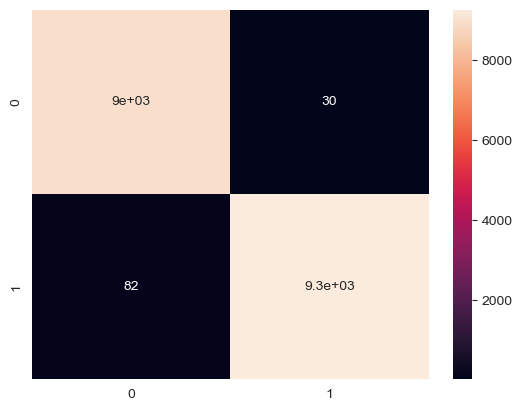

In [50]:
xg_cls_smote = xgb.XGBClassifier()
xg_cls_smote.fit(X_train_smote, y_train_smote)

cls_preds_smote = xg_cls_smote.predict(X_test_smote)

cm_smote = confusion_matrix(y_test_smote, cls_preds_smote)
sns.heatmap(cm_smote, annot=True)

accuracy_score(y_test_smote, cls_preds_smote), cm_smote

### Training XGBoost - Under sampling

In [66]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X, y)

In [67]:
X_under.shape

(468, 13)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=123)

### Experiment with encoding
Three scenarios
1. Only original features
2. Only encoding features
3. Original + Encoding features

In [74]:
# only encoding feature
drop_features = ["alert_key", "cust_id", "data_label", "sar_flag", "AGE", "date", "risk_rank", "occupation_code"]

# only original feature
# drop_features = ["alert_key", "cust_id", "data_label", "sar_flag","AGE_encoding","date_encoding","risk_rank_encoding","occupation_code_encoding"]

# original + encoding feature
# drop_features = ["alert_key", "cust_id", "data_label", "sar_flag"]

test = cinfo[cinfo['data_label'] == 'test']
X_train = X_train.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)
test = test.drop(drop_features, axis=1)

In [75]:
X_train.head()

,total_asset,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
148,10692.0,0.556931,1.293184,0.000000,0.563014
131,63344.0,0.837438,0.214133,0.000000,1.693002
437,72355.0,1.139073,1.293184,1.098901,1.062135
317,867571.0,1.139073,0.214133,3.896104,0.946970
400,84616.0,1.139073,0.214133,0.862069,0.946970


In [76]:
xg_cls = xgb.XGBClassifier()
xg_cls.fit(X_train, y_train)

cls_preds = xg_cls.predict(X_test)

The results are as follows:
- `0.7340425531914894` > only original features
- `0.8085106382978723` > only encoding features
- `0.776595744680851` > with encoding and original features

(0.776595744680851,
 array([[34, 13],
        [ 8, 39]]))

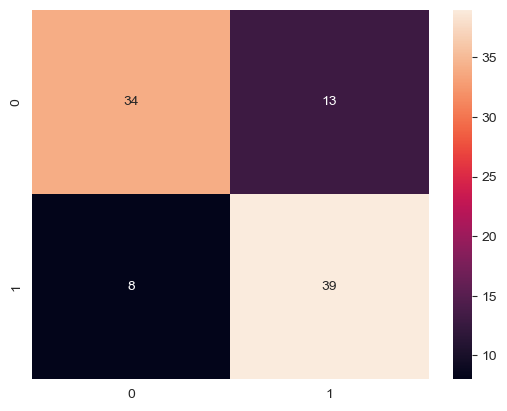

In [77]:
import seaborn as sns
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, cls_preds)
sns.heatmap(cm, annot=True)
accuracy_score(y_test, cls_preds), cm
#
# 0.6808510638297872 > only original features
# 0.776595744680851 > only encoding features
# 0.7127659574468085 > with encoding and original features


In [58]:
prob_test = [prob[1] for prob in xg_cls.predict_proba(test).tolist()]
prob_test[:10]

[0.006731611210852861,
 0.0007325871265493333,
 0.006731611210852861,
 0.0012261646334081888,
 0.003728470765054226,
 0.0010974747128784657,
 0.002279371488839388,
 0.01661984995007515,
 0.0013915064046159387,
 0.0019510122947394848]

In [59]:
non_predicted_key = sample[~sample['alert_key'].isin(test_alert_keys)]
non_predicted_key = non_predicted_key.assign(probability=0)
non_predicted_key.shape

(2005, 2)

In [60]:
submission = pd.concat([test_alert_keys, pd.DataFrame({'probability': prob_test})], axis=1)
submission = submission.sort_values(by=['probability'], ascending=False)
submission = pd.concat([submission, non_predicted_key])
submission.shape, submission.head()

((3850, 2),
       alert_key  probability
 1689     364048     0.202310
 195      354047     0.192471
 1419     361859     0.191954
 147      353566     0.191954
 1804     364718     0.177091)

In [61]:
submission.to_csv("submission_xgboost.csv", index=False)

### Aggregation using down-sampling data

In [62]:
local_path = "/Users/kneskung/Code/Datamining/esun_sar_baseline/src/"
CCBA_PATH = local_path + 'train_first/public_train_x_ccba_full_hashed.csv'
ccba = pd.read_csv(CCBA_PATH)

In [63]:
pd.unique(ccba.cust_id)

array(['0172056578071e83399216fcd640bdc4de4583149d0fd936a363abe0724afc1c',
       '0174dff6a8a2038f9966d61d8450e19e3bd751e4051c2ace42799d171742acc1',
       '01b1735c3dbf0a35c1c989bb45434ce4326b365b73db0612190e56b2858e0184',
       ...,
       'ffdbc1a5135cb6feddf7355e5656abf6973f21639c7b9b9c8a23f77a194369c9',
       'ffdd3f98b841d4d0ef58ad0d63abddac83ffb5babf973cae4f00fb64ba9b859a',
       'ffeb846f2294ec4397f800736dc1e14eb754da5425398d9a3bb81469b764b16f'],
      dtype=object)

## CCBA description
    cust_id	顧客編號	            Customer                                                    Number
    lupay	上月繳款總額	        Total payment last month	                                Numerical
	byymm	帳務年月	            Accounting year	and                                         Category
	cycam	信用額度	            credits	                                                    Numerical
	usgam	已使用額度	        Quota used	                                                Numerical
	clamt	本月分期預借現金金額	Amount of cash advance in installments this month	        Numerical
	csamt	本月預借現金金額	    Cash advance amount for this month	                        Numerical
	inamt	本月分期消費金額	    Installment spending amount for this month	                Numerical
	cucsm	本月消費金額	        Consumption of this month	                                Numerical
	cucah	本月借現金額	        Borrowed amount this month	                                Numerical

In [64]:
from collections import Counter

# From the observation each value mean month in the form of day
ccba_counter = Counter(ccba.cust_id.tolist())
most_common_cust_ids = [c[0] for c in ccba_counter.most_common()[:]]
ccba_cust_sample = ccba[ccba['cust_id'].isin(most_common_cust_ids)]
ccba_cust_sample

,cust_id,lupay,byymm,cycam,usgam,clamt,csamt,inamt,cucsm,cucah
0,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,0,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,30,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,61,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,91,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,122,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
59070,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,0.0,244,781570.0,63952.0,0.0,0.0,0.0,61927.0,0.0
59071,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,61927.0,275,781570.0,37297.0,0.0,0.0,0.0,37276.0,0.0
59072,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,37297.0,306,781570.0,45413.0,0.0,0.0,0.0,19766.0,0.0
59073,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,19766.0,334,781570.0,26360.0,0.0,0.0,1142.0,2568.0,0.0


In [65]:
import numpy as np
from tqdm import tqdm


def cal_ccba_stats(_table, _columns):
    cus_dict = {}
    _cust_ids = pd.unique(_table['cust_id'])
    _byymm = pd.unique(_table['byymm'])  # 0 1 2 3 4 5 6 ...

    print(_columns)
    for cus in tqdm(_cust_ids):
        statistic = {}
        for col in _columns:
            cus_table = _table[_table['cust_id'] == cus]
            # calculate all data
            statistic[col + '_total_mean'] = np.mean(cus_table[col])
            statistic[col + '_total_std'] = np.std(cus_table[col])
            statistic[col + '_total_sum'] = np.sum(cus_table[col])

            # comment them out first because the features are too sparse
            # calculate data for each quarter
            # range 4
            # for q in range(4):
            #     quarter = _byymm[((q) * 3):((q + 1) * 3)] # 0 1 2
            #     cus_quarter = _table[(_table['cust_id'] == cus) & (_table['byymm'].isin(quarter))]
            #     statistic[col + '_quarter' + str(q + 1) + '_mean'] = np.mean(cus_quarter[col])
            #     statistic[col + '_quarter' + str(q + 1) + '_std'] = np.std(cus_quarter[col])
            #     statistic[col + '_quarter' + str(q + 1) + '_sum'] = np.sum(cus_quarter[col])
            cus_dict[cus] = statistic
    print(("*" * 20) + " Done " + ("*" * 20))
    return cus_dict


aggregated_cust = cal_ccba_stats(ccba_cust_sample[:],
                                 ['lupay', 'byymm', 'cycam', 'usgam', 'clamt', 'csamt', 'inamt', 'cucsm', 'cucah'])
aggregated_cust

['lupay', 'byymm', 'cycam', 'usgam', 'clamt', 'csamt', 'inamt', 'cucsm', 'cucah']


 13%|█▎        | 618/4745 [00:11<01:19, 52.13it/s]


KeyboardInterrupt: 

In [ ]:
aggregated_cust_df = pd.DataFrame.from_dict(aggregated_cust)
aggregated_cust_df = aggregated_cust_df.T.fillna(0)
aggregated_cust_df.index.name = "cust_id"
aggregated_cust_df.to_pickle("aggregated_ccba_cust.pkl")
aggregated_cust_df.head()

In [ ]:
pd.unique(aggregated_cust_df.index)

In [ ]:
pd.unique(X['cust_id'])

In [ ]:
agg_cust = pd.read_pickle('aggregated_ccba_cust.pkl')

In [ ]:
pd.unique(agg_cust.index)

In [ ]:
test_aggregated = cinfo[cinfo['data_label'] == 'test']
test_aggregated = test_aggregated.merge(agg_cust, on='cust_id', how='left')
test_aggregated

In [ ]:
# cinfo = cinfo.merge(answer, on='alert_key', how='left')
X_aggreated_ccba = X.merge(agg_cust, on='cust_id', how='left')
X_aggreated_ccba.head()

In [ ]:
y_aggregated = X_aggreated_ccba['sar_flag']
y_aggregated

In [ ]:
X_aggreated_ccba[X_aggreated_ccba['sar_flag'] == 0]

In [ ]:
drop_features_aggregate = ['alert_key', 'cust_id', 'data_label']
X_aggregated_resampling = copy.deepcopy(X_aggreated_ccba)
X_aggregated_resampling = X_aggregated_resampling.drop(drop_features_aggregate, axis=1)
X_aggregated_resampling = X_aggregated_resampling.fillna(0)

y_aggregated_resampling = X_aggregated_resampling['sar_flag']
X_aggregated_resampling = X_aggregated_resampling.drop(['sar_flag'], axis=1)
test_aggregated = test_aggregated.drop(['alert_key', 'cust_id', 'data_label', 'sar_flag'], axis=1)
X_aggregated_resampling, y_aggregated_resampling = undersample.fit_resample(X_aggregated_resampling,
                                                                            y_aggregated_resampling)

In [ ]:
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_aggregated_resampling, y_aggregated_resampling,
                                                                    test_size=0.2, random_state=123)

In [ ]:
xg_cls = xgb.XGBClassifier()
xg_cls.fit(X_train_agg, y_train_agg)

cls_preds = xg_cls.predict(X_test_agg)

In [ ]:
cm = confusion_matrix(y_test_agg, cls_preds)
sns.heatmap(cm, annot=True)
accuracy_score(y_test_agg, cls_preds), cm

In [ ]:
prob_test = [prob[1] for prob in xg_cls.predict_proba(test_aggregated).tolist()]
prob_test

In [ ]:
non_predicted_key = sample[~sample['alert_key'].isin(test_alert_keys)]
non_predicted_key = non_predicted_key.assign(probability=0)
non_predicted_key.shape

In [ ]:
submission = pd.concat([test_alert_keys, pd.DataFrame({'probability': prob_test})], axis=1)
submission = submission.sort_values(by=['probability'], ascending=False)
submission = pd.concat([submission, non_predicted_key])
submission.shape, submission

In [ ]:
submission.to_csv("submission_xgboost_with_aggregate_ccba.csv", index=False)